# Importing necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pd.set_option('display.max_column', None)

# Building the DataFrame from Yahoo Finance

In [2]:
# List of popular stock symbols
symbols = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'NFLX', 'JPM',
    'V', 'WMT', 'JNJ', 'PG', 'UNH', 'HD', 'DIS', 'MA', 'VZ', 
    'ADBE', 'CSCO', 'PEP', 'KO', 'PFE', 'MRK', 'INTC', 'XOM', 'NKE', 'T'
]

# Downloading historical close prices for the given symbols from 2010 to 2024
data = yf.download(symbols, start="2010-01-01", end="2024-01-01")['Close']

data.head()

[*********************100%%**********************]  26 of 26 completed


Ticker,AAPL,ADBE,AMZN,CSCO,DIS,GOOGL,HD,INTC,JNJ,JPM,KO,MA,MRK,MSFT,NFLX,NKE,NVDA,PEP,PFE,PG,T,UNH,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,7.643214,37.090000,6.6950,24.690001,32.070000,15.684434,28.670000,20.879999,64.680000,42.849998,28.520000,25.684000,35.314884,30.950001,7.640000,16.3375,0.46225,61.240002,17.960152,61.119999,21.586103,31.530001,22.035000,31.212946,18.076668,69.150002
2010-01-05,7.656429,37.700001,6.7345,24.580000,31.990000,15.615365,28.879999,20.870001,63.930000,43.680000,28.174999,25.608000,35.458015,30.959999,7.358571,16.4025,0.46900,61.980000,17.703985,61.139999,21.480364,31.480000,21.782499,31.269218,17.896667,69.419998
2010-01-06,7.534643,37.619999,6.6125,24.420000,31.820000,15.221722,28.780001,20.799999,64.449997,43.919998,28.165001,25.556000,35.935116,30.770000,7.617143,16.3025,0.47200,61.360001,17.647058,60.849998,20.853474,31.790001,21.490000,29.937416,17.856667,70.019997
2010-01-07,7.520714,36.889999,6.5000,24.530001,31.830000,14.867367,29.120001,20.600000,63.990002,44.790001,28.094999,25.389000,35.992367,30.450001,7.485714,16.4625,0.46275,60.970001,17.580645,60.520000,20.619335,33.009998,21.690001,29.759218,17.866667,69.800003
2010-01-08,7.570714,36.689999,6.6760,24.660000,31.879999,15.065566,28.980000,20.830000,64.209999,44.680000,27.575001,25.398001,35.973282,30.660000,7.614286,16.4300,0.46375,60.770000,17.722960,60.439999,20.468279,32.700001,21.750000,29.777975,17.776667,69.519997


# Identifying the outliers

In [3]:
# Removing outliers

def remove_outliers(df, columns):
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

In [4]:
columns_to_clean = data.columns

print('Before Outlier Removal, the size of the dataframe was', data.shape)
sample_df = remove_outliers(data, columns_to_clean)
print('After Outlier Removal, the size of the dataframe is', data.shape)

Before Outlier Removal, the size of the dataframe was (3522, 26)
After Outlier Removal, the size of the dataframe is (3522, 26)


There were likely no outliers in the data, or the thresholds for detecting outliers were too lenient.

# Implementing the diverse portfolio 

In [5]:
# Calculating the annual mean returns and variances

daily_return = data.pct_change()
annual_mean_return = daily_return.mean() * 252
annual_variance_return = daily_return.var() * 252

In [6]:
# Creating a new DataFrame

stocks_data = pd.DataFrame({
    'StockSymbol': data.columns,
    'Return': annual_mean_return.values,
    'Variance': annual_variance_return.values
})

stocks_data.sample(3)

,StockSymbol,Return,Variance
11,MA,0.240128,0.078122
1,ADBE,0.249381,0.100568
23,VZ,0.030578,0.034143


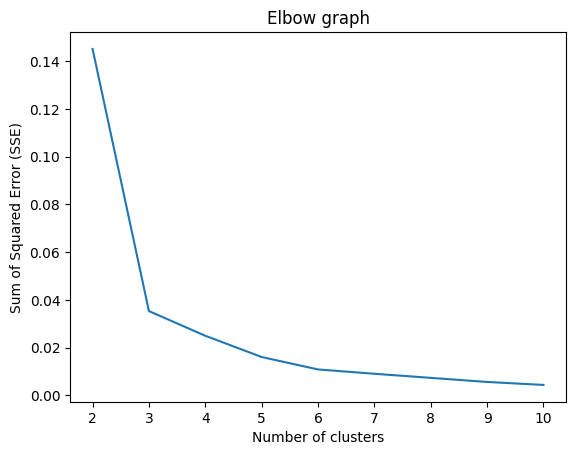

In [7]:
# Determining the number of clusters to use to group the stocks

X = stocks_data[['Return', 'Variance']].values
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)  
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia)
plt.title('Elbow graph')
plt.ylabel('Sum of Squared Error (SSE)')
plt.xlabel('Number of clusters')
plt.show()

In [8]:
# Finding the cluster labels

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10).fit(X)
labels = kmeans.labels_
stocks_data['ClusterLabel'] = labels

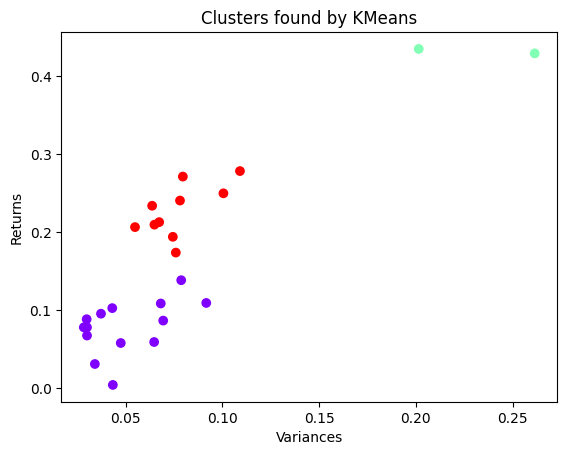

In [9]:
# Visualization of the clusters

plt.scatter(X[:, 1], X[:, 0], c=labels, cmap='rainbow')
plt.title('Clusters found by KMeans')
plt.xlabel('Variances')
plt.ylabel('Returns')
plt.show()

In [10]:
# Function for the plain diverse portfolio 

def diverse_portfolio(stocks_data, n_stocks_per_cluster):
    portfolio = []

    for cluster in sorted(stocks_data['ClusterLabel'].unique()):
        selected_stocks = stocks_data[stocks_data['ClusterLabel'] == cluster].head(n_stocks_per_cluster)
        portfolio.append(selected_stocks[['StockSymbol', 'ClusterLabel']])

    return pd.concat(portfolio).reset_index(drop=True)

In [11]:
diverse_portfolio(stocks_data, n_stocks_per_cluster=1)

,StockSymbol,ClusterLabel
0,CSCO,0
1,NFLX,1
2,AAPL,2
